In [5]:
import ase
from ase.io import read
from typing import List
import matplotlib.pyplot as plt
import numpy as np

In [12]:
FINE_TUNING_STRATEGIES = {
    "initial": "00.initial-evaluation",
    "full": "01.full-finetuning",
    "heads": "02.heads-finetuning",
    "lora": "03.lora-finetuning",
    "transfer": "04.transfer-learning"
}

def get_mae(target_atoms: List[ase.Atoms], predicted_atoms: List[ase.Atoms], target: str = 'energy') -> float:
    """
    Reads the predicted and target energies from the atoms objects and computes the 
    predictions MAE in meV/atom.
    """
    if target == 'energy':
        target_energies = np.array([item.get_potential_energy() for item in target_atoms])
        predicted_energies = np.array([item.get_potential_energy() for item in predicted_atoms])
    else:
        target_energies = np.array([item.info[target] for item in target_atoms])
        predicted_energies = np.array([item.info[target] for item in predicted_atoms])

    num_atoms = np.array([len(item) for item in target_atoms])
    target_energies_per_atom = target_energies / num_atoms
    predicted_energies_per_atom = predicted_energies / num_atoms

    mae = np.mean(np.abs(target_energies_per_atom - predicted_energies_per_atom)) * 1000  # Convert to meV/atom
    return mae

# 1. Loading the fine-tuning results and computing the MAE

In [13]:
Li3PS4_target_atoms = read("shared/datasets/Li3PS4-sample/test.xyz", ":")
MAD_target_atoms = read("shared/datasets/MAD-sample/test.xyz", ":")
fine_tuning_results = {}
for strategy, path in FINE_TUNING_STRATEGIES.items():
    Li3PS4_predicted_atoms = read(f"{path}/Li3PS4-sample-test-predictions.xyz", ":")
    MAD_predicted_atoms = read(f"{path}/MAD-sample-test-predictions.xyz", ":")
    if strategy == "transfer":
        target = 'mtt::r2scan_energy'
    else:
        target = 'energy'
    fine_tuning_results[strategy] = {
        "Li3PS4": get_mae(Li3PS4_target_atoms, Li3PS4_predicted_atoms, target=target),
        "MAD": get_mae(MAD_target_atoms, MAD_predicted_atoms)
    }

# 2. Plotting the results

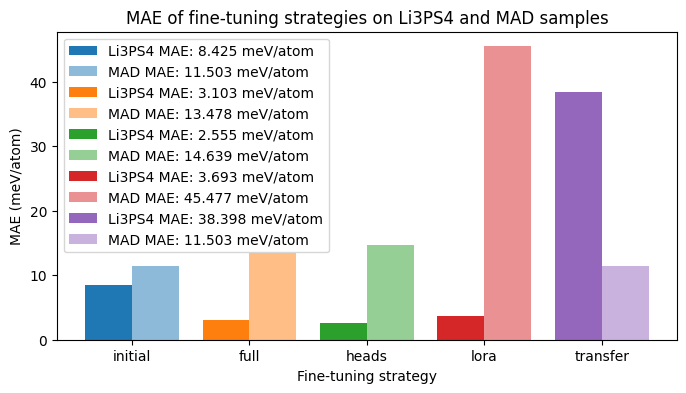

In [15]:
plt.figure(figsize=(8, 4))
for i, strategy in enumerate(FINE_TUNING_STRATEGIES):
    Li3PS4_mae = fine_tuning_results[strategy]["Li3PS4"]
    MAD_mae = fine_tuning_results[strategy]["MAD"]
    x = list(FINE_TUNING_STRATEGIES.keys()).index(strategy)
    plt.bar(x - 0.2, Li3PS4_mae, width=0.4, color=f"C{i}",
            label=f"Li3PS4 MAE: {Li3PS4_mae:.3f} meV/atom")
    plt.bar(x + 0.2, MAD_mae, width=0.4, color=f"C{i}", alpha=0.5,
            label=f"MAD MAE: {MAD_mae:.3f} meV/atom")
    plt.xticks(range(len(FINE_TUNING_STRATEGIES)), list(FINE_TUNING_STRATEGIES.keys()))
    

plt.xlabel("Fine-tuning strategy")
plt.ylabel("MAE (meV/atom)")
plt.title("MAE of fine-tuning strategies on Li3PS4 and MAD samples")
plt.legend()
plt.show()